In [1]:
import importlib
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, preprocess_dataset
from pathlib import Path
from mrcnn import visualize
import colorsys
import random
import numpy as np
import mrcnn.model as modellib
from mrcnn.model import log
import scipy.io as sio
import json

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Explore the dataset with the annotations for the car part classification

In [2]:
def draw_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [3]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [4]:
colors = random_colors(30)

In [5]:
part_annotation_files = Path(
    '../../../car-damage-estimation/data/car_part/trainval/Annotations_Part/')
images_path = Path('../../../car-damage-estimation/data/VOCdevkit/VOC2010/JPEGImages/')

images_annotations_files = list(Path(part_annotation_files).glob('*.mat'))

## Prepare the datasets

In [6]:
dataset_train, dataset_val, dataset_test = prepare_datasets(images_path, images_annotations_files, 0.7, 0.8)

100%|██████████| 10103/10103 [02:19<00:00, 72.27it/s]


In [7]:
print(dataset_train.num_images, dataset_val.num_images, dataset_test.num_images)

715 102 205


### Check some images

In [8]:
i = 3

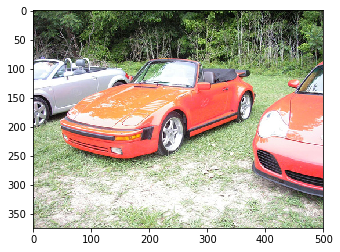

In [9]:
img = dataset_train.load_image(i)
plt.imshow(img)

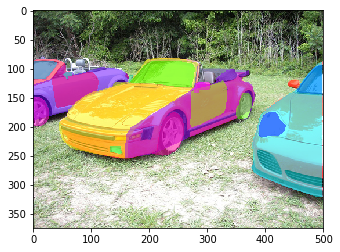

In [10]:
mask, classes = dataset_train.load_mask(i)
img_copy = img.copy()

for l in range(mask.shape[-1]):
    img_copy = draw_mask(img_copy, mask[:,:,l], colors[l])
    
plt.imshow(img_copy)

In [11]:
class_map = dict(zip(dataset_train.class_names, dataset_train.class_ids))
class_map = {k : str(v) for k,v in class_map.items()}

In [12]:
with open('./carpart_id_map.json', 'w') as f:
    json.dump(class_map, f)

In [13]:
class_map

{'BG': '0',
 'frontside': '1',
 'rightside': '2',
 'window_1': '3',
 'headlight_1': '4',
 'wheel_1': '5',
 'fliplate': '6',
 'rightmirror': '7',
 'headlight_2': '8',
 'wheel_2': '9',
 'window_2': '10',
 'leftside': '11',
 'door_1': '12',
 'leftmirror': '13',
 'window_3': '14',
 'backside': '15',
 'wheel_3': '16',
 'window_4': '17',
 'window_5': '18',
 'window_6': '19',
 'bliplate': '20',
 'roofside': '21',
 'door_2': '22',
 'wheel_4': '23',
 'headlight_3': '24',
 'headlight_4': '25',
 'wheel_5': '26',
 'headlight_5': '27',
 'headlight_6': '28',
 'door_3': '29',
 'window_7': '30'}

## Image Augmentation

An example of image augmentation applied to the images

In [79]:
import imgaug as ia
import imgaug.augmenters as iaa

In [106]:
image = img
image_mask = mask

In [107]:
segmap = ia.SegmentationMapOnImage(mask, shape=image.shape, nb_classes=len(class_map))

In [322]:
seq = iaa.OneOf([
    iaa.Noop(),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.AverageBlur(k=(2, 11)),
    iaa.Affine(scale=(.5, 2.)),
    iaa.Affine(scale={"x": (.5, 2.), "y": (.5, 2.)}),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(shear=(-16, 16)),
    iaa.CropAndPad(percent=(-0.25, 0.25)),
])

In [329]:
# Augment images and heatmaps.
images_aug = []
segmaps_aug = []
updates = []
for _ in range(5):
    seq_det = seq.to_deterministic()
    images_aug.append(seq_det.augment_image(image))
    segmaps_aug.append(seq_det.augment_segmentation_maps([segmap])[0])

In [330]:
cells = []
for image_aug, segmap_aug in zip(images_aug, segmaps_aug):
    cells.append(image)                                      # column 1
    cells.append(segmap.draw_on_image(image))                # column 2
    cells.append(image_aug)                                  # column 3
    cells.append(segmap_aug.draw_on_image(image_aug))        # column 4
    cells.append(segmap_aug.draw(size=image_aug.shape[:2]))  # column 5

In [331]:
grid_image = ia.draw_grid(cells, cols=5)

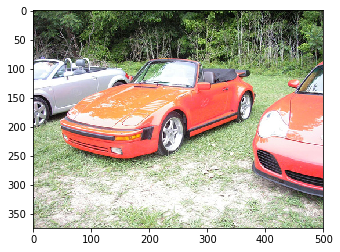

In [332]:
plt.imshow(img)

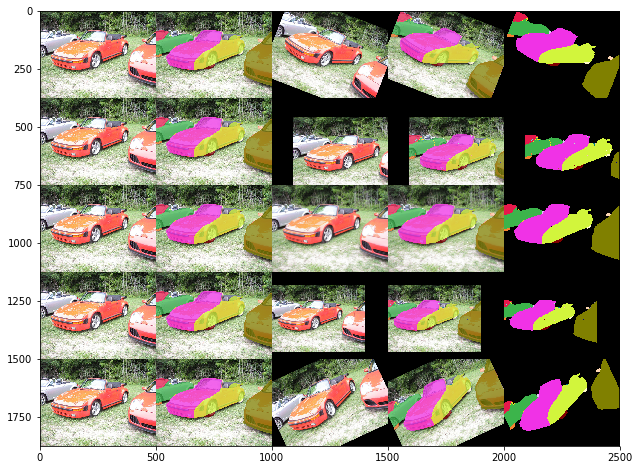

In [333]:
fig = plt.figure(figsize=(16,8))
ax = plt.subplot()
ax.imshow(grid_image)